In [1]:
import numpy as np
import scipy.linalg as la
from scipy.integrate import ode
import scipy
from scipy import signal
import utils
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [2]:
def find_boundary(coefficient_matrix, data, threshold):
    boundary_data = np.zeros(coefficient_matrix.shape[0])
    for i in range(boundary_data.size):
        entries_above = np.where(coefficient_matrix[i] > threshold)
        if entries_above[0].size==0:
            index=0
        else:
            index = np.max(entries_above)+1
        if index==coefficient_matrix.shape[1]:
            boundary_data[i]=np.inf
        else:
            boundary_data[i]=data[index]
    return boundary_data

## Two Van der Pol

In [3]:
poly_order = 3
coefficient_threshold = .001
tol = 1e-10

mu=5
c1=0.005
c2=1

x0=[0.0,2.0,2.0,0.0]

### Uniform sampling

In [4]:
num_periods_simulate = 1
sampling_rate_simulate_exponent = 14
sampling_rate_simulate = 2**sampling_rate_simulate_exponent

frequency_multipliers = np.arange(10,110,10)
test_durations = np.arange(.05,1.05,.05)

sampling_rate_exponent = 12
sampling_rate = 2**sampling_rate_exponent
spacing = sampling_rate_simulate//sampling_rate

total_samples = np.zeros((frequency_multipliers.size, test_durations.size))
extra_coefficients = np.zeros((frequency_multipliers.size, test_durations.size))

for idx,frequency_multiplier in enumerate(frequency_multipliers):
    tau_fast = .2
    tau_slow = tau_fast*frequency_multiplier

    fast_period_length = 11.45015*tau_fast
    slow_period_length = fast_period_length*frequency_multiplier

    Xi_true = np.zeros((35,4))
    Xi_true[2,0] = 1
    Xi_true[3,0] = c1
    Xi_true[1,1] = -1
    Xi_true[2,1] = mu
    Xi_true[16,1] = -mu
    Xi_true[:,:2] /= tau_fast
    Xi_true[1,2] = c2
    Xi_true[4,2] = 1
    Xi_true[3,3] = -1
    Xi_true[4,3] = mu
    Xi_true[32,3] = -mu
    Xi_true[:,2:] /= tau_slow
    
    t_simulate = np.linspace(0, num_periods_simulate*slow_period_length,
                    int(num_periods_simulate*sampling_rate_simulate*slow_period_length/fast_period_length))
    dt_simulate = t_simulate[1]-t_simulate[0]
    
    initial_samples = int(5*sampling_rate_simulate)
    vdp_simulation = utils.simulate_coupled_vdp(dt_simulate, t_simulate.size+initial_samples, x0=x0,
                                              mu1=mu, mu2=mu, c1=c1, c2=c2,
                                              tau1=tau_fast, tau2=tau_slow)[0][:,initial_samples:]
    
    for i,duration in enumerate(test_durations):
        # get subsamples
        t_max_idx = int(duration*frequency_multiplier*sampling_rate_simulate)+1

        t_sample = t_simulate[:t_max_idx:spacing]
        dt_sample = t_sample[1] - t_sample[0]
        total_samples[idx,i] = t_sample.size

        sampled_data = vdp_simulation[:,:t_max_idx:spacing]

        sindy = utils.SINDy()
        sindy.fit(sampled_data, poly_order, t=dt_sample, coefficient_threshold=coefficient_threshold)
        extra_coefficients[idx,i] = np.where(((np.abs(Xi_true) < tol) & (np.abs(sindy.Xi) > tol))\
                                              | ((np.abs(Xi_true) > tol) & (np.abs(sindy.Xi) < tol)))[0].size

vdp_data = [frequency_multipliers,
            find_boundary(extra_coefficients, test_durations, 0)*frequency_multipliers*sampling_rate]

### Burst sampling

In [5]:
np.random.seed(1)

frequency_multipliers = np.arange(10,110,10)
subsample_chunks_exponent = np.arange(2,12)

subsample_chunk_size_exponent = 3
subsample_chunk_size = 2**subsample_chunk_size_exponent

extra_coefficients = np.zeros((frequency_multipliers.size, subsample_chunks_exponent.size))
incorrect_trial_fraction = np.zeros((frequency_multipliers.size, subsample_chunks_exponent.size))
total_samples = np.zeros((frequency_multipliers.size, subsample_chunks_exponent.size))

subsample_duration = 2
num_trials=100

for idx,frequency_multiplier in enumerate(frequency_multipliers):
    tau_fast = 0.2
    tau_slow = tau_fast*frequency_multiplier

    fast_period_length = 11.45015*tau_fast
    slow_period_length = fast_period_length*frequency_multiplier

    Xi_true = np.zeros((35,4))
    Xi_true[2,0] = 1
    Xi_true[3,0] = c1
    Xi_true[1,1] = -1
    Xi_true[2,1] = mu
    Xi_true[16,1] = -mu
    Xi_true[:,:2] /= tau_fast
    Xi_true[1,2] = c2
    Xi_true[4,2] = 1
    Xi_true[3,3] = -1
    Xi_true[4,3] = mu
    Xi_true[32,3] = -mu
    Xi_true[:,2:] /= tau_slow
    
    num_periods_simulate = 3
    sampling_rate_simulate_exponent = 12
    sampling_rate_simulate = 2**sampling_rate_simulate_exponent
    t_simulate = np.linspace(0, num_periods_simulate*slow_period_length,
                    int(num_periods_simulate*sampling_rate_simulate*frequency_multiplier))
    dt_simulate = t_simulate[1]-t_simulate[0]

    sampling_rate_base_exponent = 12
    sampling_rate_base = 2**sampling_rate_base_exponent
    spacing = 2**(sampling_rate_simulate_exponent - sampling_rate_base_exponent)
    t_sample = t_simulate[::spacing]
    dt_sample = t_sample[1] - t_sample[0]
    
    initial_samples = 5*sampling_rate_simulate
    vdp_simulation = utils.simulate_coupled_vdp(dt_simulate, t_simulate.size+initial_samples, x0=[0,2,2,0],
                                              mu1=mu, mu2=mu, c1=c1, c2=c2,
                                              tau1=tau_fast, tau2=tau_slow)[0][:,initial_samples:]
    vdp_solution = vdp_simulation[:,::spacing]
        
    for j,subsample_chunk_exponent in enumerate(subsample_chunks_exponent):
        subsample_chunk = 2**subsample_chunk_exponent

        expected_samples = subsample_chunk*subsample_chunk_size
        t_max_idx = int(subsample_duration*frequency_multiplier*sampling_rate_base)+1

        subsample_start_idxs = np.linspace(0, t_max_idx-subsample_chunk_size, subsample_chunk).astype(int)
        sample_separation = subsample_start_idxs[1] - subsample_chunk_size
        if (expected_samples/t_max_idx > .9) or (sample_separation <= 5):
            total_samples[idx,j] = np.nan
            extra_coefficients[idx,j] = np.nan
            incorrect_trial_fraction[idx,j] = np.nan
            continue

        for trial in range(num_trials):    
            subsample_start_idxs = np.linspace(0, t_max_idx-subsample_chunk_size, subsample_chunk).astype(int)
            sample_separation = subsample_start_idxs[1] - subsample_chunk_size
            subsample_offsets = np.random.randint(sample_separation-1, size=subsample_chunk-2)\
                                - (sample_separation-1)//2
            subsample_start_idxs[1:-1] += subsample_offsets
            subsample_idxs = np.unique(np.sort((subsample_start_idxs[:,np.newaxis] \
                                                + np.arange(subsample_chunk_size)).flatten()))

            t_subsample = t_sample[subsample_idxs]

            total_samples[idx,j] = t_subsample.size
            subsampled_data = vdp_solution[:,subsample_idxs]
            sindy = utils.SINDy()
            sindy.fit(subsampled_data, poly_order, t_subsample, dt_max=1.5*dt_sample,
                      coefficient_threshold=coefficient_threshold)
            tmp = np.where(((np.abs(Xi_true) < tol) & (np.abs(sindy.Xi) > tol))\
                            | ((np.abs(Xi_true) > tol) & (np.abs(sindy.Xi) < tol)))[0].size
            extra_coefficients[idx,j] += tmp
            if tmp>0:
                incorrect_trial_fraction[idx,j] += 1

extra_coefficients /= num_trials
incorrect_trial_fraction /= num_trials

vdp_burst_data0 = [frequency_multipliers,
                         (2**find_boundary(incorrect_trial_fraction,
                                           subsample_chunks_exponent, 0))*(2**subsample_chunk_size_exponent)]
vdp_burst_data05 = [frequency_multipliers,
                         (2**find_boundary(incorrect_trial_fraction,
                                           subsample_chunks_exponent, 0.05))*(2**subsample_chunk_size_exponent)]

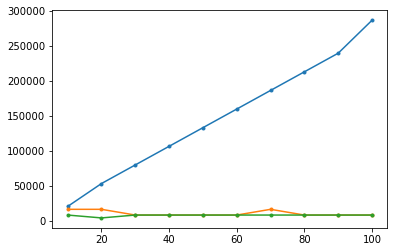

In [6]:
plt.figure()
plt.plot(vdp_data[0], vdp_data[1], '.-')
plt.plot(vdp_burst_data0[0], vdp_burst_data0[1], '.-')
plt.plot(vdp_burst_data05[0], vdp_burst_data05[1], '.-')

## Slow Van der Pol, fast Lorenz

In [7]:
poly_order = 3
coefficient_threshold = .001
tol = 1e-10

mu=5
sigma=10.
rho=28.
beta=8/3
c1=0.01
c2=10

x0 = [0.0, 2.0, -8.0, 7.0, 27.0]

lorenz_base_period_length = .759
vdp_base_period_length = 11.45015

### Uniform sampling

In [8]:
num_periods_simulate = 1.5
sampling_rate_simulate_exponent = 14
sampling_rate_simulate = 2**sampling_rate_simulate_exponent

frequency_multipliers = np.arange(10,110,10)
test_durations = np.arange(.05,1.05,.05)

sampling_rate_exponent = 11
sampling_rate = 2**sampling_rate_exponent
spacing = sampling_rate_simulate//sampling_rate

total_samples = np.zeros((frequency_multipliers.size, test_durations.size))
extra_coefficients = np.zeros((frequency_multipliers.size, test_durations.size))

for idx,frequency_multiplier in enumerate(frequency_multipliers):
    tau_vdp = .05*frequency_multiplier
    tau_lorenz = .05*vdp_base_period_length/lorenz_base_period_length

    fast_period_length = tau_lorenz*lorenz_base_period_length
    slow_period_length = tau_vdp*vdp_base_period_length

    Xi_true = np.zeros((56,5))
    Xi_true[2,0] = 1
    Xi_true[3,0] = c1
    Xi_true[1,1] = -1
    Xi_true[2,1] = mu
    Xi_true[22,1] = -mu
    Xi_true[:,0:2] /= tau_vdp
    Xi_true[1,2] = c2
    Xi_true[3,2] = -sigma
    Xi_true[4,2] = sigma
    Xi_true[3,3] = rho
    Xi_true[4,3] = -1
    Xi_true[17,3] = -1
    Xi_true[5,4] = -beta
    Xi_true[16,4] = 1
    Xi_true[:,2:] /= tau_lorenz
    
    t_simulate = np.linspace(0, num_periods_simulate*slow_period_length,
                    int(num_periods_simulate*sampling_rate_simulate*slow_period_length/fast_period_length))
    dt_simulate = t_simulate[1]-t_simulate[0]
    
    initial_samples = int(6*sampling_rate_simulate)
    vdp_lorenz_simulation = utils.simulate_coupled_vdp_lorenz(dt_simulate, t_simulate.size+initial_samples, x0=x0,
                                                 mu=mu, sigma=sigma, rho=rho, beta=beta, c1=c1, c2=c2,
                                                 tau1=tau_vdp, tau2=tau_lorenz)[0][:,initial_samples:]
    
    for i,duration in enumerate(test_durations):
        # get subsamples
        t_max_idx = int(duration*frequency_multiplier*sampling_rate_simulate)+1

        t_sample = t_simulate[:t_max_idx:spacing]
        dt_sample = t_sample[1] - t_sample[0]
        total_samples[idx,i] = t_sample.size

        sampled_data = vdp_lorenz_simulation[:,:t_max_idx:spacing]

        sindy = utils.SINDy()
        sindy.fit(sampled_data, poly_order, t=dt_sample, coefficient_threshold=coefficient_threshold)
        extra_coefficients[idx,i] = np.where(((np.abs(Xi_true) < tol) & (np.abs(sindy.Xi) > tol))\
                                              | ((np.abs(Xi_true) > tol) & (np.abs(sindy.Xi) < tol)))[0].size

vdplorenz1_data = [frequency_multipliers,
                   find_boundary(extra_coefficients, test_durations, 0)*frequency_multipliers*sampling_rate]

### Burst sampling

In [9]:
np.random.seed(2)

frequency_multipliers = np.arange(10,110,10)
subsample_chunks_exponent = np.arange(2,13)

subsample_chunk_size_exponent = 3
subsample_chunk_size = 2**subsample_chunk_size_exponent

extra_coefficients = np.zeros((frequency_multipliers.size, subsample_chunks_exponent.size))
incorrect_trial_fraction = np.zeros((frequency_multipliers.size, subsample_chunks_exponent.size))
total_samples = np.zeros((frequency_multipliers.size, subsample_chunks_exponent.size))

subsample_duration = 2
num_trials=100

for idx,frequency_multiplier in enumerate(frequency_multipliers):
    tau_vdp = .05*frequency_multiplier
    tau_lorenz = .05*vdp_base_period_length/lorenz_base_period_length

    fast_period_length = tau_lorenz*lorenz_base_period_length
    slow_period_length = tau_vdp*vdp_base_period_length

    Xi_true = np.zeros((56,5))
    Xi_true[2,0] = 1
    Xi_true[3,0] = c1
    Xi_true[1,1] = -1
    Xi_true[2,1] = mu
    Xi_true[22,1] = -mu
    Xi_true[:,0:2] /= tau_vdp
    Xi_true[1,2] = c2
    Xi_true[3,2] = -sigma
    Xi_true[4,2] = sigma
    Xi_true[3,3] = rho
    Xi_true[4,3] = -1
    Xi_true[17,3] = -1
    Xi_true[5,4] = -beta
    Xi_true[16,4] = 1
    Xi_true[:,2:] /= tau_lorenz
    
    num_periods_simulate = 2.5
    sampling_rate_simulate_exponent = 12
    sampling_rate_simulate = 2**sampling_rate_simulate_exponent
    t_simulate = np.linspace(0, num_periods_simulate*slow_period_length,
                    int(num_periods_simulate*sampling_rate_simulate*frequency_multiplier))
    dt_simulate = t_simulate[1]-t_simulate[0]

    sampling_rate_base_exponent = 11
    sampling_rate_base = 2**sampling_rate_base_exponent
    spacing = 2**(sampling_rate_simulate_exponent - sampling_rate_base_exponent)
    t_sample = t_simulate[::spacing]
    dt_sample = t_sample[1] - t_sample[0]
    
    initial_samples = 6*sampling_rate_simulate
    vdp_lorenz_simulation = utils.simulate_coupled_vdp_lorenz(dt_simulate, t_simulate.size+initial_samples, x0=x0,
                                                 mu=mu, sigma=sigma, rho=rho, beta=beta, c1=c1, c2=c2,
                                                 tau1=tau_vdp, tau2=tau_lorenz)[0][:,initial_samples:]
    vdp_lorenz_solution = vdp_lorenz_simulation[:,::spacing]
        
    for j,subsample_chunk_exponent in enumerate(subsample_chunks_exponent):
        subsample_chunk = 2**subsample_chunk_exponent

        expected_samples = subsample_chunk*subsample_chunk_size
        t_max_idx = int(subsample_duration*frequency_multiplier*sampling_rate_base)+1

        subsample_start_idxs = np.linspace(0, t_max_idx-subsample_chunk_size, subsample_chunk).astype(int)
        sample_separation = subsample_start_idxs[1] - subsample_chunk_size
        if (expected_samples/t_max_idx > .9) or (sample_separation <= 5):
            total_samples[idx,j] = np.nan
            extra_coefficients[idx,j] = np.nan
            incorrect_trial_fraction[idx,j] = np.nan
            continue

        for trial in range(num_trials):    
            subsample_start_idxs = np.linspace(0, t_max_idx-subsample_chunk_size, subsample_chunk).astype(int)
            sample_separation = subsample_start_idxs[1] - subsample_chunk_size
            subsample_offsets = np.random.randint(sample_separation-1, size=subsample_chunk-2)\
                                - (sample_separation-1)//2
            subsample_start_idxs[1:-1] += subsample_offsets
            subsample_idxs = np.unique(np.sort((subsample_start_idxs[:,np.newaxis] \
                                                + np.arange(subsample_chunk_size)).flatten()))

            t_subsample = t_sample[subsample_idxs]

            total_samples[idx,j] = t_subsample.size
            subsampled_data = vdp_lorenz_solution[:,subsample_idxs]
            sindy = utils.SINDy()
            sindy.fit(subsampled_data, poly_order, t_subsample, dt_max=1.5*dt_sample,
                      coefficient_threshold=coefficient_threshold)
            tmp = np.where(((np.abs(Xi_true) < tol) & (np.abs(sindy.Xi) > tol))\
                            | ((np.abs(Xi_true) > tol) & (np.abs(sindy.Xi) < tol)))[0].size
            extra_coefficients[idx,j] += tmp
            if tmp>0:
                incorrect_trial_fraction[idx,j] += 1

extra_coefficients /= num_trials
incorrect_trial_fraction /= num_trials

In [10]:
vdplorenz1_burst_data0 = [frequency_multipliers,
                         (2**find_boundary(incorrect_trial_fraction,
                                           subsample_chunks_exponent, 0))*(2**subsample_chunk_size_exponent)]
vdplorenz1_burst_data05 = [frequency_multipliers,
                         (2**find_boundary(incorrect_trial_fraction,
                                           subsample_chunks_exponent, 0.05))*(2**subsample_chunk_size_exponent)]

/home/kpchamp/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


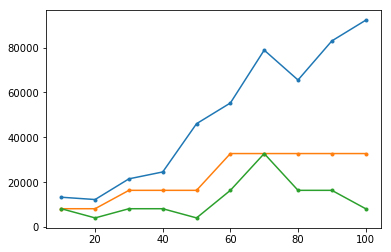

In [11]:
plt.figure()
plt.plot(vdplorenz1_data[0], vdplorenz1_data[1], '.-')
plt.plot(vdplorenz1_burst_data0[0], vdplorenz1_burst_data0[1], '.-')
plt.plot(vdplorenz1_burst_data05[0], vdplorenz1_burst_data05[1], '.-')

## Fast Van der Pol, slow Lorenz

In [12]:
poly_order = 3
coefficient_threshold = .002
tol = 1e-10

mu=5
sigma=10.
rho=28.
beta=8/3
c1=.005
c2=10

x0 = [0.0, 2.0, -8.0, 7.0, 27.0]

lorenz_base_period_length = .759
vdp_base_period_length = 11.45015

### Uniform sampling

In [13]:
num_periods_simulate = 1.5
sampling_rate_simulate_exponent = 14
sampling_rate_simulate = 2**sampling_rate_simulate_exponent

frequency_multipliers = np.arange(10,110,10)
test_durations = np.arange(.1,1.5,.1)

sampling_rate_exponent = 12
sampling_rate = 2**sampling_rate_exponent
spacing = sampling_rate_simulate//sampling_rate

total_samples = np.zeros((frequency_multipliers.size, test_durations.size))
extra_coefficients = np.zeros((frequency_multipliers.size, test_durations.size))

for idx,frequency_multiplier in enumerate(frequency_multipliers):
    tau_lorenz = 2*frequency_multiplier
    tau_vdp = 2*lorenz_base_period_length/vdp_base_period_length

    fast_period_length = tau_vdp*vdp_base_period_length
    slow_period_length = tau_lorenz*lorenz_base_period_length

    Xi_true = np.zeros((56,5))
    Xi_true[2,0] = 1
    Xi_true[3,0] = c1
    Xi_true[1,1] = -1
    Xi_true[2,1] = mu
    Xi_true[22,1] = -mu
    Xi_true[:,0:2] /= tau_vdp
    Xi_true[1,2] = c2
    Xi_true[3,2] = -sigma
    Xi_true[4,2] = sigma
    Xi_true[3,3] = rho
    Xi_true[4,3] = -1
    Xi_true[17,3] = -1
    Xi_true[5,4] = -beta
    Xi_true[16,4] = 1
    Xi_true[:,2:] /= tau_lorenz
    
    t_simulate = np.linspace(0, num_periods_simulate*slow_period_length,
                    int(num_periods_simulate*sampling_rate_simulate*slow_period_length/fast_period_length))
    dt_simulate = t_simulate[1]-t_simulate[0]
    
    initial_samples = 6*sampling_rate_simulate
    vdp_lorenz_simulation = utils.simulate_coupled_vdp_lorenz(dt_simulate, t_simulate.size+initial_samples, x0=x0,
                                                 mu=mu, sigma=sigma, rho=rho, beta=beta, c1=c1, c2=c2,
                                                 tau1=tau_vdp, tau2=tau_lorenz)[0][:,initial_samples:]
    
    for i,duration in enumerate(test_durations):
        # get subsamples
        t_max_idx = int(duration*frequency_multiplier*sampling_rate_simulate)+1

        t_sample = t_simulate[:t_max_idx:spacing]
        dt_sample = t_sample[1] - t_sample[0]
        total_samples[idx,i] = t_sample.size

        sampled_data = vdp_lorenz_simulation[:,:t_max_idx:spacing]

        sindy = utils.SINDy()
        sindy.fit(sampled_data, poly_order, t=dt_sample, coefficient_threshold=coefficient_threshold)
        extra_coefficients[idx,i] = np.where(((np.abs(Xi_true) < tol) & (np.abs(sindy.Xi) > tol))\
                                              | ((np.abs(Xi_true) > tol) & (np.abs(sindy.Xi) < tol)))[0].size

In [14]:
vdplorenz2_data = [frequency_multipliers,
                   find_boundary(extra_coefficients, test_durations, 0)*frequency_multipliers*sampling_rate]

### Burst sampling

In [15]:
np.random.seed(3)

frequency_multipliers = np.arange(10,110,10)
subsample_chunks_exponent = np.arange(2,13)

subsample_chunk_size_exponent = 3
subsample_chunk_size = 2**subsample_chunk_size_exponent

extra_coefficients = np.zeros((frequency_multipliers.size, subsample_chunks_exponent.size))
incorrect_trial_fraction = np.zeros((frequency_multipliers.size, subsample_chunks_exponent.size))
total_samples = np.zeros((frequency_multipliers.size, subsample_chunks_exponent.size))

subsample_duration = 2
num_trials=100

for idx,frequency_multiplier in enumerate(frequency_multipliers):
    tau_lorenz = 2*frequency_multiplier
    tau_vdp = 2*lorenz_base_period_length/vdp_base_period_length

    fast_period_length = tau_vdp*vdp_base_period_length
    slow_period_length = tau_lorenz*lorenz_base_period_length

    Xi_true = np.zeros((56,5))
    Xi_true[2,0] = 1
    Xi_true[3,0] = c1
    Xi_true[1,1] = -1
    Xi_true[2,1] = mu
    Xi_true[22,1] = -mu
    Xi_true[:,0:2] /= tau_vdp
    Xi_true[1,2] = c2
    Xi_true[3,2] = -sigma
    Xi_true[4,2] = sigma
    Xi_true[3,3] = rho
    Xi_true[4,3] = -1
    Xi_true[17,3] = -1
    Xi_true[5,4] = -beta
    Xi_true[16,4] = 1
    Xi_true[:,2:] /= tau_lorenz
    
    num_periods_simulate = 2.5
    sampling_rate_simulate_exponent = 12
    sampling_rate_simulate = 2**sampling_rate_simulate_exponent
    t_simulate = np.linspace(0, num_periods_simulate*slow_period_length,
                    int(num_periods_simulate*sampling_rate_simulate*frequency_multiplier))
    dt_simulate = t_simulate[1]-t_simulate[0]

    sampling_rate_base_exponent = 12
    sampling_rate_base = 2**sampling_rate_base_exponent
    spacing = 2**(sampling_rate_simulate_exponent - sampling_rate_base_exponent)
    t_sample = t_simulate[::spacing]
    dt_sample = t_sample[1] - t_sample[0]
    
    initial_samples = 5*sampling_rate_simulate
    vdp_lorenz_simulation = utils.simulate_coupled_vdp_lorenz(dt_simulate, t_simulate.size+initial_samples, x0=x0,
                                                 mu=mu, sigma=sigma, rho=rho, beta=beta, c1=c1, c2=c2,
                                                 tau1=tau_vdp, tau2=tau_lorenz)[0][:,initial_samples:]
    vdp_lorenz_solution = vdp_lorenz_simulation[:,::spacing]
        
    for j,subsample_chunk_exponent in enumerate(subsample_chunks_exponent):
        subsample_chunk = 2**subsample_chunk_exponent

        expected_samples = subsample_chunk*subsample_chunk_size
        t_max_idx = int(subsample_duration*frequency_multiplier*sampling_rate_base)+1

        subsample_start_idxs = np.linspace(0, t_max_idx-subsample_chunk_size, subsample_chunk).astype(int)
        sample_separation = subsample_start_idxs[1] - subsample_chunk_size
        if (expected_samples/t_max_idx > .9) or (sample_separation <= 5):
            total_samples[idx,j] = np.nan
            extra_coefficients[idx,j] = np.nan
            incorrect_trial_fraction[idx,j] = np.nan
            continue

        for trial in range(num_trials):    
            subsample_start_idxs = np.linspace(0, t_max_idx-subsample_chunk_size, subsample_chunk).astype(int)
            sample_separation = subsample_start_idxs[1] - subsample_chunk_size
            subsample_offsets = np.random.randint(sample_separation-1, size=subsample_chunk-2)\
                                - (sample_separation-1)//2
            subsample_start_idxs[1:-1] += subsample_offsets
            subsample_idxs = np.unique(np.sort((subsample_start_idxs[:,np.newaxis] \
                                                + np.arange(subsample_chunk_size)).flatten()))

            t_subsample = t_sample[subsample_idxs]

            total_samples[idx,j] = t_subsample.size
            subsampled_data = vdp_lorenz_solution[:,subsample_idxs]
            sindy = utils.SINDy()
            sindy.fit(subsampled_data, poly_order, t_subsample, dt_max=1.5*dt_sample,
                      coefficient_threshold=coefficient_threshold)
            tmp = np.where(((np.abs(Xi_true) < tol) & (np.abs(sindy.Xi) > tol))\
                            | ((np.abs(Xi_true) > tol) & (np.abs(sindy.Xi) < tol)))[0].size
            extra_coefficients[idx,j] += tmp
            if tmp>0:
                incorrect_trial_fraction[idx,j] += 1

extra_coefficients /= num_trials
incorrect_trial_fraction /= num_trials

vdplorenz2_burst_data0 = [frequency_multipliers,
                         (2**find_boundary(incorrect_trial_fraction,
                                           subsample_chunks_exponent, 0))*(2**subsample_chunk_size_exponent)]
vdplorenz2_burst_data05 = [frequency_multipliers,
                         (2**find_boundary(incorrect_trial_fraction,
                                           subsample_chunks_exponent, 0.05))*(2**subsample_chunk_size_exponent)]

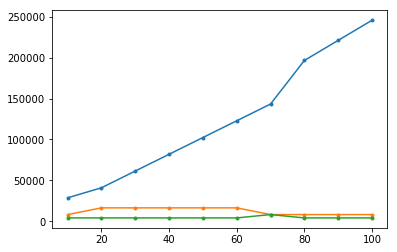

In [16]:
plt.figure()
plt.plot(vdplorenz2_data[0], vdplorenz2_data[1], '.-')
plt.plot(vdplorenz2_burst_data0[0], vdplorenz2_burst_data0[1], '.-')
plt.plot(vdplorenz2_burst_data05[0], vdplorenz2_burst_data05[1], '.-')

# Plot all results

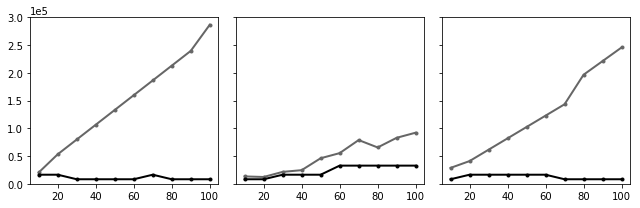

In [30]:
fig = plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.plot(vdp_data[0], vdp_data[1], '.-', color='#666666', linewidth=2)
plt.plot(vdp_burst_data0[0], vdp_burst_data0[1], '.-k', linewidth=2)
plt.ylim([0,3e5])
# plt.yticks(np.arange(0,3.5e5,5e4), np.arange(0,3.5,.5))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,4))

plt.subplot(1,3,2)
plt.plot(vdplorenz1_data[0], vdplorenz1_data[1], '.-', color='#666666',
         linewidth=2)
plt.plot(vdplorenz1_burst_data0[0], vdplorenz1_burst_data0[1], '.-k', linewidth=2)
plt.ylim([0,3e5])
plt.yticks(np.arange(0,3.5e5,5e4), [])

plt.subplot(1,3,3)
plt.plot(vdplorenz2_data[0], vdplorenz2_data[1], '.-', color='#666666',
        linewidth=2)
plt.plot(vdplorenz2_burst_data0[0], vdplorenz2_burst_data0[1], '.-k', linewidth=2)
plt.ylim([0,3e5])
plt.yticks(np.arange(0,3.5e5,5e4), [])

plt.tight_layout()
plt.savefig('figures/04.pdf', format='pdf', dpi=300)